## 1. Import Libraries

In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import (
    Dinov2ForImageClassification,
    ViTForImageClassification,
    SwinForImageClassification,
    AutoModelForImageClassification
)
import timm
import time
import random
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from torchinfo import summary

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Setup Configuration

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
train_data = r'C:\Users\shiva\Desktop\Inference\good_bad_scratches\train'
val_data = r'C:\Users\shiva\Desktop\Inference\good_bad_scratches\val'
test_data = r'C:\Users\shiva\Desktop\Inference\good_bad_scratches\test'

# Training configuration
num_epochs = 50
batch_size = 32
learning_rate = 0.0001

print(f"\n✓ Paths configured")
print(f"  Train: {train_data}")
print(f"  Val: {val_data}")
print(f"  Test: {test_data}")
print(f"\n✓ Training configuration")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")

Using device: cuda

✓ Paths configured
  Train: C:\Users\shiva\Desktop\Inference\good_bad_scratches\train
  Val: C:\Users\shiva\Desktop\Inference\good_bad_scratches\val
  Test: C:\Users\shiva\Desktop\Inference\good_bad_scratches\test

✓ Training configuration
  Epochs: 50
  Batch size: 32
  Learning rate: 0.0001


## 3. Define Data Transforms

**Note:** 
- **Training** uses augmentation (flips, rotations) to make learning more robust
- **Validation & Test** use the same transforms (no augmentation) for fair evaluation

In [4]:
# Training transforms for ResNet50, MobileNetV3, DINOv2 (224x224) - WITH augmentation
train_transforms_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Evaluation transforms (Val & Test) for 224x224 models - NO augmentation
eval_transforms_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Training transforms for InceptionV3 (299x299) - WITH augmentation
train_transforms_299 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Evaluation transforms (Val & Test) for InceptionV3 (299x299) - NO augmentation
eval_transforms_299 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

print("✓ Data transforms defined")
print("  Train: WITH augmentation (flips, rotations)")
print("  Val/Test: WITHOUT augmentation (clean images)")

✓ Data transforms defined
  Train: WITH augmentation (flips, rotations)
  Val/Test: WITHOUT augmentation (clean images)


## 5. Visualize Sample Images from Dataset

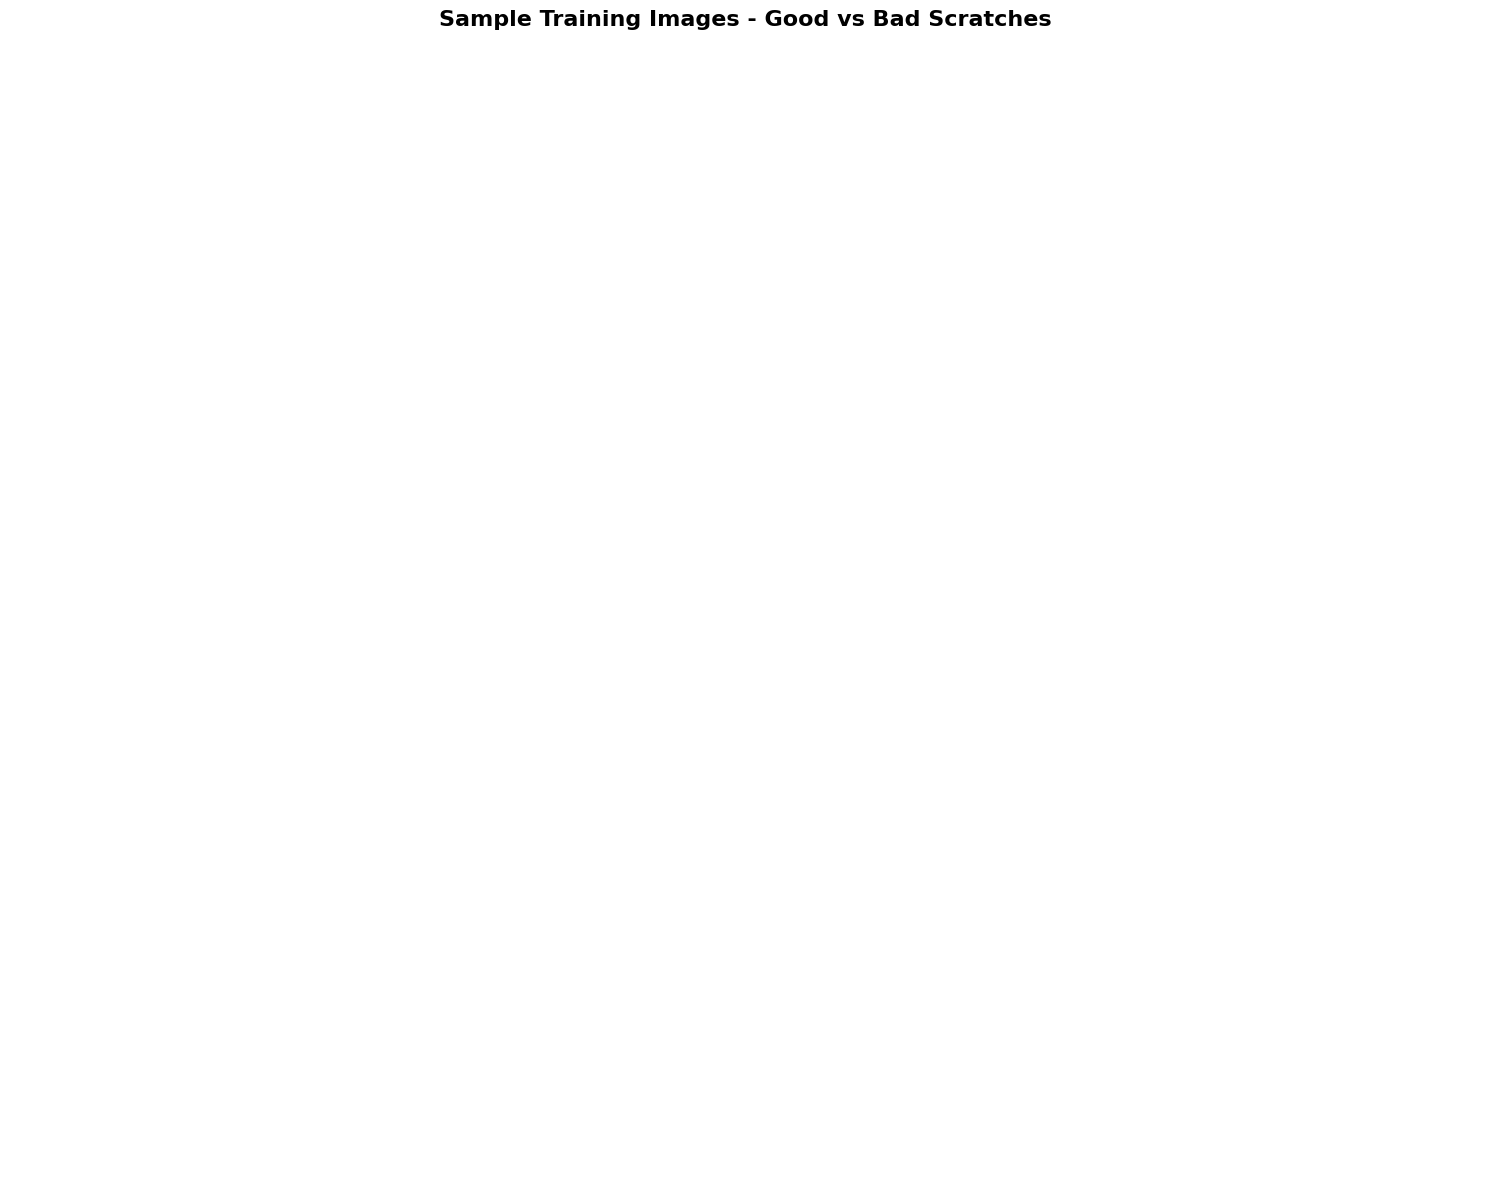

✓ Sample images displayed
  Found 0 good samples
  Found 0 bad samples


In [5]:
import cv2
import glob

# Visualize sample images from training set
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Training Images - Good vs Bad Scratches', fontsize=16, fontweight='bold')

# Get sample good images
good_images = glob.glob(os.path.join(train_data, 'good', '*.png'))[:10]
good_images += glob.glob(os.path.join(train_data, 'good', '*.jpg'))[:10-len(good_images)]

# Get sample bad images
bad_images = glob.glob(os.path.join(train_data, 'bad', '*.png'))[:10]
bad_images += glob.glob(os.path.join(train_data, 'bad', '*.jpg'))[:10-len(bad_images)]

# Display good images (top 2 rows)
for i in range(10):
    row = i // 5
    col = i % 5
    
    if i < len(good_images):
        img = cv2.imread(good_images[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img_rgb)
        axes[row, col].set_title('GOOD', color='green', fontweight='bold', fontsize=10)
    axes[row, col].axis('off')

# Display bad images (bottom 2 rows)
for i in range(10):
    row = (i // 5) + 2
    col = i % 5
    
    if i < len(bad_images):
        img = cv2.imread(bad_images[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img_rgb)
        axes[row, col].set_title('BAD', color='red', fontweight='bold', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Sample images displayed")
print(f"  Found {len(good_images)} good samples")
print(f"  Found {len(bad_images)} bad samples")

## 4. Load Datasets

**Transform Application:**
- **Train dataset:** Uses augmentation transforms
- **Val dataset:** Uses evaluation transforms (no augmentation)
- **Test dataset:** Uses evaluation transforms (no augmentation)

In [5]:
# Load datasets for 224x224 models
train_dataset_224 = ImageFolder(root=train_data, transform=train_transforms_224)
val_dataset_224 = ImageFolder(root=val_data, transform=eval_transforms_224)
test_dataset_224 = ImageFolder(root=test_data, transform=eval_transforms_224)

# Load datasets for InceptionV3 (299x299)
train_dataset_299 = ImageFolder(root=train_data, transform=train_transforms_299)
val_dataset_299 = ImageFolder(root=val_data, transform=eval_transforms_299)
test_dataset_299 = ImageFolder(root=test_data, transform=eval_transforms_299)

num_classes = len(train_dataset_224.classes)
class_names = train_dataset_224.classes

print(f"✓ Datasets loaded")
print(f"  Classes: {class_names}")
print(f"  Num classes: {num_classes}")
print(f"  Train samples: {len(train_dataset_224)}")
print(f"  Val samples: {len(val_dataset_224)}")
print(f"  Test samples: {len(test_dataset_224)}")

# Create dataloaders
train_dataloader_224 = DataLoader(train_dataset_224, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader_224 = DataLoader(val_dataset_224, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader_224 = DataLoader(test_dataset_224, batch_size=batch_size, shuffle=False, num_workers=0)

train_dataloader_299 = DataLoader(train_dataset_299, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader_299 = DataLoader(val_dataset_299, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader_299 = DataLoader(test_dataset_299, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_sizes_224 = {'train': len(train_dataset_224), 'val': len(val_dataset_224)}
dataset_sizes_299 = {'train': len(train_dataset_299), 'val': len(val_dataset_299)}

print(f"\n✓ DataLoaders created")


✓ Datasets loaded
  Classes: ['bad', 'good']
  Num classes: 2
  Train samples: 5818
  Val samples: 1246
  Test samples: 1250

✓ DataLoaders created


## 6. Define Training Functions

In [6]:
class EarlyStopping:
    """Early stops training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): Print messages when stopping
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
    
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'  ⚠️  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'\n  🛑 Early stopping triggered! Best epoch was {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0

print("✓ EarlyStopping class defined")

✓ EarlyStopping class defined


In [7]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, dataset_sizes, device, num_epochs=20, model_name="Model", patience=5):
    """
    Train a model with validation tracking and early stopping.
    """
    best_acc = 0.0
    best_model_wts = model.state_dict()
    train_latency = 0.0
    best_epoch = 0

    # Store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_latencies = []
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print(f"Early Stopping: Enabled (patience={patience})")
    print(f"{'='*70}\n")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0
            start_time = time.time()

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    # Handle different output formats
                    if hasattr(outputs, 'logits'):
                        logits = outputs.logits
                    elif isinstance(outputs, tuple):
                        logits = outputs[0]  # InceptionV3 returns tuple
                    else:
                        logits = outputs

                    loss = criterion(logits, labels)
                    preds = torch.argmax(logits, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            end_time = time.time()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            latency = end_time - start_time

            # Store metrics
            if phase == 'train':
                train_latency += latency
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc * 100)
            else:
                val_latencies.append(latency)
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc * 100)

            print(f'{phase.capitalize():5s} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {latency:.2f}s')

            if phase == 'val':
                # Check early stopping
                early_stopping(epoch_loss, epoch)
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    best_epoch = epoch + 1

        print()
        
        # Stop training if early stopping is triggered
        if early_stopping.early_stop:
            print(f"Training stopped at epoch {epoch + 1}")
            break

    model.load_state_dict(best_model_wts)
    print(f'\n✓ Best Validation Accuracy: {best_acc:.4f} (Epoch {best_epoch})')
    print(f'✓ Total Training Time: {train_latency:.2f}s\n')

    return model, train_losses, val_losses, train_accuracies, val_accuracies, val_latencies

print("✓ Training function defined with early stopping")

✓ Training function defined with early stopping


## 7. Models 



#### 1. RESNET50

In [8]:
# Load ResNet50
model_resnet = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
model_resnet = model_resnet.to(device)

# Freeze backbone, unfreeze classifier
for param in model_resnet.parameters():
    param.requires_grad = False
for param in model_resnet.fc.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=learning_rate)

print("✓ ResNet50 model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_resnet.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)}")

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

✓ ResNet50 model loaded
  Total parameters: 23512130
  Trainable parameters: 4098


In [9]:
# Train ResNet50
model_resnet, resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs, resnet_val_latencies = train_model(
    model_resnet, criterion_resnet, optimizer_resnet,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "ResNet50"
)


Training ResNet50
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.6764 Acc: 0.6207 Time: 63.78s
Val   Loss: 0.6221 Acc: 0.9246 Time: 12.55s

Epoch 2/50
----------------------------------------
Train Loss: 0.6452 Acc: 0.7090 Time: 36.64s
Val   Loss: 0.5681 Acc: 0.9591 Time: 7.31s

Epoch 3/50
----------------------------------------
Train Loss: 0.6219 Acc: 0.7183 Time: 36.58s
Val   Loss: 0.5442 Acc: 0.9494 Time: 7.51s

Epoch 4/50
----------------------------------------
Train Loss: 0.6012 Acc: 0.7279 Time: 36.95s
Val   Loss: 0.5045 Acc: 0.9470 Time: 7.47s

Epoch 5/50
----------------------------------------
Train Loss: 0.5840 Acc: 0.7305 Time: 37.30s
Val   Loss: 0.4986 Acc: 0.9430 Time: 7.51s

Epoch 6/50
----------------------------------------
Train Loss: 0.5735 Acc: 0.7398 Time: 38.03s
Val   Loss: 0.4818 Acc: 0.9213 Time: 7.49s

Epoch 7/50
----------------------------------------
Train Loss: 0.5584 Acc: 0.7539 Time: 37.38s
Val   

In [10]:
# Save ResNet50
torch.save(model_resnet.state_dict(), 'resnet50_binary.pth')
print("✓ ResNet50 model saved")

✓ ResNet50 model saved


####  2: InceptionV3

In [11]:
# Load InceptionV3
model_inception = timm.create_model('inception_v3', pretrained=True, num_classes=num_classes)
model_inception = model_inception.to(device)

# Freeze backbone, unfreeze classifier
for param in model_inception.parameters():
    param.requires_grad = False
for param in model_inception.fc.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.Adam(model_inception.fc.parameters(), lr=learning_rate)

print("✓ InceptionV3 model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_inception.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_inception.parameters() if p.requires_grad)}")

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

✓ InceptionV3 model loaded
  Total parameters: 21789666
  Trainable parameters: 4098


In [12]:
# Train InceptionV3
model_inception, inception_train_losses, inception_val_losses, inception_train_accs, inception_val_accs, inception_val_latencies = train_model(
    model_inception, criterion_inception, optimizer_inception,
    train_dataloader_299, val_dataloader_299, dataset_sizes_299,
    device, num_epochs, "InceptionV3"
)


Training InceptionV3
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.8388 Acc: 0.5342 Time: 52.21s
Val   Loss: 0.7463 Acc: 0.5722 Time: 10.37s

Epoch 2/50
----------------------------------------
Train Loss: 0.7163 Acc: 0.6011 Time: 51.69s
Val   Loss: 0.7280 Acc: 0.5650 Time: 10.30s

Epoch 3/50
----------------------------------------
Train Loss: 0.6567 Acc: 0.6401 Time: 51.46s
Val   Loss: 0.6784 Acc: 0.6083 Time: 10.31s

Epoch 4/50
----------------------------------------
Train Loss: 0.6112 Acc: 0.6698 Time: 51.75s
Val   Loss: 0.6577 Acc: 0.6075 Time: 10.33s

Epoch 5/50
----------------------------------------
Train Loss: 0.5737 Acc: 0.7040 Time: 52.03s
Val   Loss: 0.6419 Acc: 0.6196 Time: 10.31s

Epoch 6/50
----------------------------------------
Train Loss: 0.5583 Acc: 0.7198 Time: 52.04s
Val   Loss: 0.6038 Acc: 0.6581 Time: 10.28s

Epoch 7/50
----------------------------------------
Train Loss: 0.5284 Acc: 0.7322 Time: 51.84

In [13]:
# Save InceptionV3
torch.save(model_inception.state_dict(), 'inceptionv3_binary.pth')
print("✓ InceptionV3 model saved")

✓ InceptionV3 model saved


####  MobileNetV3

In [14]:
# Load MobileNetV3
model_mobilenet = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=num_classes)
model_mobilenet = model_mobilenet.to(device)

# Freeze backbone, unfreeze classifier
for param in model_mobilenet.parameters():
    param.requires_grad = False
for param in model_mobilenet.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_mobilenet = nn.CrossEntropyLoss()
optimizer_mobilenet = optim.Adam(model_mobilenet.classifier.parameters(), lr=learning_rate)

print("✓ MobileNetV3 model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_mobilenet.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_mobilenet.parameters() if p.requires_grad)}")

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

✓ MobileNetV3 model loaded
  Total parameters: 4204594
  Trainable parameters: 2562


In [15]:
# Train MobileNetV3
model_mobilenet, mobilenet_train_losses, mobilenet_val_losses, mobilenet_train_accs, mobilenet_val_accs, mobilenet_val_latencies = train_model(
    model_mobilenet, criterion_mobilenet, optimizer_mobilenet,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "MobileNetV3"
)


Training MobileNetV3
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 2.3030 Acc: 0.4661 Time: 25.89s
Val   Loss: 1.6389 Acc: 0.5626 Time: 5.29s

Epoch 2/50
----------------------------------------
Train Loss: 1.9724 Acc: 0.4986 Time: 26.14s
Val   Loss: 1.6001 Acc: 0.5722 Time: 5.36s

Epoch 3/50
----------------------------------------
Train Loss: 1.8053 Acc: 0.5282 Time: 25.87s
Val   Loss: 1.3211 Acc: 0.6340 Time: 5.26s

Epoch 4/50
----------------------------------------
Train Loss: 1.6658 Acc: 0.5435 Time: 25.64s
Val   Loss: 1.2413 Acc: 0.6421 Time: 5.11s

Epoch 5/50
----------------------------------------
Train Loss: 1.5241 Acc: 0.5660 Time: 25.75s
Val   Loss: 1.3869 Acc: 0.6132 Time: 5.31s
  ⚠️  EarlyStopping counter: 1/5

Epoch 6/50
----------------------------------------
Train Loss: 1.4449 Acc: 0.5847 Time: 25.81s
Val   Loss: 1.4449 Acc: 0.5915 Time: 5.06s
  ⚠️  EarlyStopping counter: 2/5

Epoch 7/50
-----------------------

In [16]:
# Save MobileNetV3
torch.save(model_mobilenet.state_dict(), 'mobilenetv3_binary.pth')
print("✓ MobileNetV3 model saved")

✓ MobileNetV3 model saved


####  DINOv2

In [17]:
# Load DINOv2
model_dinov2 = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base", num_labels=num_classes)
model_dinov2 = model_dinov2.to(device)

# Freeze backbone, unfreeze classifier
for param in model_dinov2.dinov2.parameters():
    param.requires_grad = False
for param in model_dinov2.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_dinov2 = nn.CrossEntropyLoss()
optimizer_dinov2 = optim.Adam(model_dinov2.parameters(), lr=learning_rate)

print("✓ DINOv2 model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_dinov2.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_dinov2.parameters() if p.requires_grad)}")

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ DINOv2 model loaded
  Total parameters: 86583554
  Trainable parameters: 3074


In [18]:
# Train DINOv2
model_dinov2, dinov2_train_losses, dinov2_val_losses, dinov2_train_accs, dinov2_val_accs, dinov2_val_latencies = train_model(
    model_dinov2, criterion_dinov2, optimizer_dinov2,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "DINOv2"
)


Training DINOv2
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.4698 Acc: 0.7924 Time: 106.64s
Val   Loss: 0.5258 Acc: 0.6966 Time: 22.76s

Epoch 2/50
----------------------------------------
Train Loss: 0.2677 Acc: 0.9065 Time: 106.63s
Val   Loss: 0.4795 Acc: 0.7376 Time: 22.65s

Epoch 3/50
----------------------------------------
Train Loss: 0.2147 Acc: 0.9256 Time: 106.64s
Val   Loss: 0.4811 Acc: 0.7512 Time: 22.56s
  ⚠️  EarlyStopping counter: 1/5

Epoch 4/50
----------------------------------------
Train Loss: 0.1857 Acc: 0.9359 Time: 106.43s
Val   Loss: 0.4144 Acc: 0.7905 Time: 22.54s

Epoch 5/50
----------------------------------------
Train Loss: 0.1638 Acc: 0.9448 Time: 106.59s
Val   Loss: 0.4106 Acc: 0.7945 Time: 22.54s

Epoch 6/50
----------------------------------------
Train Loss: 0.1454 Acc: 0.9510 Time: 108.04s
Val   Loss: 0.4173 Acc: 0.7961 Time: 23.15s
  ⚠️  EarlyStopping counter: 1/5

Epoch 7/50
----------------

In [19]:
# Save MobileNetV3
torch.save(model_dinov2.state_dict(), 'model_dinov2_binary.pth')
print("✓ model_dinov2 model saved")

✓ model_dinov2 model saved


#### VIT-BASE

In [20]:
# Load ViT-Base
model_vit_base = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
)
model_vit_base = model_vit_base.to(device)

# Freeze backbone, unfreeze classifier
for param in model_vit_base.vit.parameters():
    param.requires_grad = False
for param in model_vit_base.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_vit_base = nn.CrossEntropyLoss()
optimizer_vit_base = optim.Adam(model_vit_base.classifier.parameters(), lr=learning_rate)

print("✓ ViT-Base model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_vit_base.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_vit_base.parameters() if p.requires_grad)}")



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT-Base model loaded
  Total parameters: 85800194
  Trainable parameters: 1538


In [21]:
# Train ViT-Base
model_vit_base, vit_base_train_losses, vit_base_val_losses, vit_base_train_accs, vit_base_val_accs, vit_base_val_latencies = train_model(
    model_vit_base, criterion_vit_base, optimizer_vit_base,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "ViT-Base", patience=5
)


Training ViT-Base
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.6714 Acc: 0.6021 Time: 82.73s
Val   Loss: 0.6185 Acc: 0.8122 Time: 17.39s

Epoch 2/50
----------------------------------------
Train Loss: 0.6197 Acc: 0.6903 Time: 82.62s
Val   Loss: 0.5851 Acc: 0.7352 Time: 17.65s

Epoch 3/50
----------------------------------------
Train Loss: 0.5831 Acc: 0.7477 Time: 82.30s
Val   Loss: 0.5724 Acc: 0.6597 Time: 17.43s

Epoch 4/50
----------------------------------------
Train Loss: 0.5548 Acc: 0.7676 Time: 82.79s
Val   Loss: 0.5628 Acc: 0.6525 Time: 17.46s

Epoch 5/50
----------------------------------------
Train Loss: 0.5314 Acc: 0.7879 Time: 82.66s
Val   Loss: 0.5550 Acc: 0.6645 Time: 17.53s

Epoch 6/50
----------------------------------------
Train Loss: 0.5114 Acc: 0.8006 Time: 82.28s
Val   Loss: 0.5510 Acc: 0.6557 Time: 17.51s

Epoch 7/50
----------------------------------------
Train Loss: 0.4973 Acc: 0.8053 Time: 82.25s
V

In [22]:
# Save ViT-Base
torch.save(model_vit_base.state_dict(), 'vit_base_binary.pth')
print("✓ ViT-Base model saved")

✓ ViT-Base model saved


#### VIT-LARGE

In [23]:
# Load ViT-Large
model_vit_large = ViTForImageClassification.from_pretrained(
    "google/vit-large-patch16-224-in21k",
    num_labels=num_classes
)
model_vit_large = model_vit_large.to(device)

# Freeze backbone, unfreeze classifier
for param in model_vit_large.vit.parameters():
    param.requires_grad = False
for param in model_vit_large.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_vit_large = nn.CrossEntropyLoss()
optimizer_vit_large = optim.Adam(model_vit_large.classifier.parameters(), lr=learning_rate)

print("✓ ViT-Large model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_vit_large.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_vit_large.parameters() if p.requires_grad)}")



config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT-Large model loaded
  Total parameters: 303303682
  Trainable parameters: 2050


In [24]:
# Train ViT-Large
model_vit_large, vit_large_train_losses, vit_large_val_losses, vit_large_train_accs, vit_large_val_accs, vit_large_val_latencies = train_model(
    model_vit_large, criterion_vit_large, optimizer_vit_large,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "ViT-Large", patience=5
)



Training ViT-Large
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.5856 Acc: 0.7286 Time: 221.76s
Val   Loss: 0.5026 Acc: 0.7681 Time: 47.79s

Epoch 2/50
----------------------------------------
Train Loss: 0.4801 Acc: 0.8212 Time: 222.75s
Val   Loss: 0.4459 Acc: 0.7897 Time: 47.61s

Epoch 3/50
----------------------------------------
Train Loss: 0.4282 Acc: 0.8463 Time: 222.06s
Val   Loss: 0.4008 Acc: 0.8186 Time: 47.59s

Epoch 4/50
----------------------------------------
Train Loss: 0.3892 Acc: 0.8627 Time: 224.44s
Val   Loss: 0.3938 Acc: 0.8178 Time: 48.10s

Epoch 5/50
----------------------------------------
Train Loss: 0.3581 Acc: 0.8774 Time: 224.38s
Val   Loss: 0.3999 Acc: 0.7961 Time: 48.09s
  ⚠️  EarlyStopping counter: 1/5

Epoch 6/50
----------------------------------------
Train Loss: 0.3372 Acc: 0.8840 Time: 223.08s
Val   Loss: 0.3936 Acc: 0.7970 Time: 47.86s

Epoch 7/50
----------------------------------------
Train

In [25]:
# Save ViT-Large
torch.save(model_vit_large.state_dict(), 'vit_large_binary.pth')
print("✓ ViT-Large model saved")

✓ ViT-Large model saved


#### DEIT

In [ ]:
# -------------------------
# Download HF model files locally and load with local_files_only
# -------------------------
import os
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

# CONFIG
model_name_or_repo = "facebook/deit-base-distilled-patch16-224"  # model repo on HF
local_dir = "./hf_deit_local"                                     # where to store files locally
num_classes = 2                                                   # your # of labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(local_dir, exist_ok=True)

# Files we try to download from the repo. Some repos use 'preprocessor_config.json' or 'feature_extractor_config.json'.
candidates = [
    "config.json",
    "pytorch_model.bin",
    "tf_model.h5",
    "flax_model.msgpack",
    "preprocessor_config.json",
    "feature_extractor_config.json",
    "tokenizer_config.json",
    "README.md"
]

print(f"Downloading files for '{model_name_or_repo}' into {local_dir} (using huggingface_hub)...")
downloaded = {}
for fname in candidates:
    try:
        # cache_dir specifies where hf_hub will store the file; it will create subfolders, but it's OK.
        path = hf_hub_download(repo_id=model_name_or_repo, filename=fname, repo_type="model", cache_dir=local_dir)
        downloaded[fname] = path
        print(f" -> {fname} -> {path}")
    except Exception as e:
        # file may not exist in the repo; continue
        print(f"   ✖ {fname}: {e}")

if "pytorch_model.bin" not in downloaded and "flax_model.msgpack" not in downloaded and "tf_model.h5" not in downloaded:
    print("\nWarning: model weights were not downloaded. Check network or the model repo name.")
else:
    print("\nDownloaded available files. Now loading the model locally (no online access).")

# Load processor & model from the local directory using local_files_only=True
# Hugging Face will search for files in the folder and the cache tree previously created.
try:
    processor = AutoImageProcessor.from_pretrained(local_dir, local_files_only=True)
    print("Loaded AutoImageProcessor from local files.")
except Exception as e:
    print(f"AutoImageProcessor local load failed: {e}")
    processor = None

try:
    model = AutoModelForImageClassification.from_pretrained(
        local_dir,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        local_files_only=True
    )
    model.to(device)
    print("Loaded model from local files and moved to device:", device)
except Exception as e:
    print("Model local load failed:", e)
    model = None

# Quick sanity: print model class and keys of files found in local_dir
print("\nSanity check:")
print(" local_dir exists:", os.path.exists(local_dir))
print(" files in local_dir (top-level):", os.listdir(local_dir)[:50])
if model:
    print(" Model type:", type(model).__name__)
if processor:
    # processor may be ImageProcessor/FeatureExtractor subclass
    print(" Processor type:", type(processor).__name__)


config.json: 0.00B [00:00, ?B/s]

 -> config.json -> ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/config.json


pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

 -> pytorch_model.bin -> ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/pytorch_model.bin


tf_model.h5:   0%|          | 0.00/350M [00:00<?, ?B/s]

 -> tf_model.h5 -> ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/tf_model.h5
   ✖ flax_model.msgpack: 404 Client Error. (Request ID: Root=1-69204267-783471c05a881ee1566d71ae;df53626a-b8d1-4e88-8b9f-f154a8674056)

Entry Not Found for url: https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/flax_model.msgpack.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

 -> preprocessor_config.json -> ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/preprocessor_config.json
   ✖ feature_extractor_config.json: 404 Client Error. (Request ID: Root=1-69204267-1cd2b87508c93543557b5264;98e129e4-9e59-42d5-ac2c-5472a7291130)

Entry Not Found for url: https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/feature_extractor_config.json.
   ✖ tokenizer_config.json: 404 Client Error. (Request ID: Root=1-69204267-1600ea8f6372ba7039263dde;5f454c3d-afff-4c40-a17c-2513ab5c58a2)

Entry Not Found for url: https://huggingface.co/facebook/deit-base-distilled-patch16-224/resolve/main/tokenizer_config.json.


README.md: 0.00B [00:00, ?B/s]

 -> README.md -> ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/README.md

Downloaded available files. Now loading the model locally (no online access).
AutoImageProcessor local load failed: ./hf_deit_local does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/./hf_deit_local/tree/main' for available files.
Model local load failed: 'NoneType' object is not iterable

Sanity check:
 local_dir exists: True
 files in local_dir (top-level): ['models--facebook--deit-base-distilled-patch16-224', '.locks']


In [27]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

base_dir = "./hf_deit_local"
repo_subdir = "models--facebook--deit-base-distilled-patch16-224"
snapshot_root = os.path.join(base_dir, repo_subdir, "snapshots")

# Find snapshot folder automatically (it’s a hash)
snapshot_folders = os.listdir(snapshot_root)
assert len(snapshot_folders) > 0, "No snapshots found!"
model_dir = os.path.join(snapshot_root, snapshot_folders[0])  # pick first snapshot

print("✅ Found local snapshot:", model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # change to your actual number of labels

# Load from snapshot folder (works completely offline)
try:
    processor = AutoImageProcessor.from_pretrained(model_dir, local_files_only=True)
    print("Loaded processor from snapshot.")
except Exception as e:
    print("Processor load failed:", e)
    processor = None

try:
    model_deit = AutoModelForImageClassification.from_pretrained(
        model_dir,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        local_files_only=True
    ).to(device)
    print("✅ Loaded model successfully from local snapshot to device:", device)
except Exception as e:
    print("❌ Model load failed:", e)

criterion_deit = nn.CrossEntropyLoss()
optimizer_deit = optim.AdamW(model_deit.parameters(), lr=learning_rate)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Found local snapshot: ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea
Loaded processor from snapshot.


Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at ./hf_deit_local/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model successfully from local snapshot to device: cuda


In [28]:
# Train DeiT
model_deit, deit_train_losses, deit_val_losses, deit_train_accs, deit_val_accs, deit_val_latencies = train_model(
    model_deit, criterion_deit, optimizer_deit,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "DeiT", patience=5
)


Training DeiT
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.1089 Acc: 0.9569 Time: 215.51s
Val   Loss: 0.2995 Acc: 0.8788 Time: 17.83s

Epoch 2/50
----------------------------------------
Train Loss: 0.0319 Acc: 0.9895 Time: 212.62s
Val   Loss: 0.4075 Acc: 0.8812 Time: 17.55s
  ⚠️  EarlyStopping counter: 1/5

Epoch 3/50
----------------------------------------
Train Loss: 0.0260 Acc: 0.9933 Time: 212.71s
Val   Loss: 0.5093 Acc: 0.8210 Time: 17.56s
  ⚠️  EarlyStopping counter: 2/5

Epoch 4/50
----------------------------------------
Train Loss: 0.0143 Acc: 0.9957 Time: 212.28s
Val   Loss: 0.9226 Acc: 0.8130 Time: 17.53s
  ⚠️  EarlyStopping counter: 3/5

Epoch 5/50
----------------------------------------
Train Loss: 0.0247 Acc: 0.9911 Time: 212.37s
Val   Loss: 0.4874 Acc: 0.8917 Time: 17.54s
  ⚠️  EarlyStopping counter: 4/5

Epoch 6/50
----------------------------------------
Train Loss: 0.0195 Acc: 0.9940 Time: 212.47s
Val   Lo

In [29]:
# Save DeiT
torch.save(model_deit.state_dict(), 'deit_binary.pth')
print("✓ DeiT model saved")

✓ DeiT model saved


#### SWIN

In [30]:
# Load Swin Transformer
model_swin = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model_swin = model_swin.to(device)

# Freeze backbone, unfreeze classifier
for param in model_swin.swin.parameters():
    param.requires_grad = False
for param in model_swin.classifier.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion_swin = nn.CrossEntropyLoss()
optimizer_swin = optim.Adam(model_swin.classifier.parameters(), lr=learning_rate)

print("✓ Swin Transformer model loaded")
print(f"  Total parameters: {sum(p.numel() for p in model_swin.parameters())}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_swin.parameters() if p.requires_grad)}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Swin Transformer model loaded
  Total parameters: 86747324
  Trainable parameters: 4100


In [31]:
# Train Swin Transformer
model_swin, swin_train_losses, swin_val_losses, swin_train_accs, swin_val_accs, swin_val_latencies = train_model(
    model_swin, criterion_swin, optimizer_swin,
    train_dataloader_224, val_dataloader_224, dataset_sizes_224,
    device, num_epochs, "Swin Transformer", patience=5
)


Training Swin Transformer
Early Stopping: Enabled (patience=5)

Epoch 1/50
----------------------------------------
Train Loss: 0.6876 Acc: 0.6861 Time: 89.46s
Val   Loss: 0.4973 Acc: 0.8074 Time: 18.77s

Epoch 2/50
----------------------------------------
Train Loss: 0.4702 Acc: 0.8353 Time: 89.16s
Val   Loss: 0.4422 Acc: 0.7673 Time: 18.71s

Epoch 3/50
----------------------------------------
Train Loss: 0.3977 Acc: 0.8668 Time: 89.21s
Val   Loss: 0.4219 Acc: 0.7648 Time: 18.67s

Epoch 4/50
----------------------------------------
Train Loss: 0.3642 Acc: 0.8704 Time: 89.28s
Val   Loss: 0.3889 Acc: 0.8050 Time: 18.89s

Epoch 5/50
----------------------------------------
Train Loss: 0.3317 Acc: 0.8807 Time: 89.06s
Val   Loss: 0.3855 Acc: 0.7986 Time: 18.69s

Epoch 6/50
----------------------------------------
Train Loss: 0.3139 Acc: 0.8871 Time: 88.83s
Val   Loss: 0.4102 Acc: 0.7761 Time: 18.76s
  ⚠️  EarlyStopping counter: 1/5

Epoch 7/50
----------------------------------------
Trai

In [32]:
# Save Swin Transformer
torch.save(model_swin.state_dict(), 'swin_binary.pth')
print("✓ Swin Transformer model saved")

✓ Swin Transformer model saved


#### Training Visuals

📊 CNN MODELS TRAINING CURVES


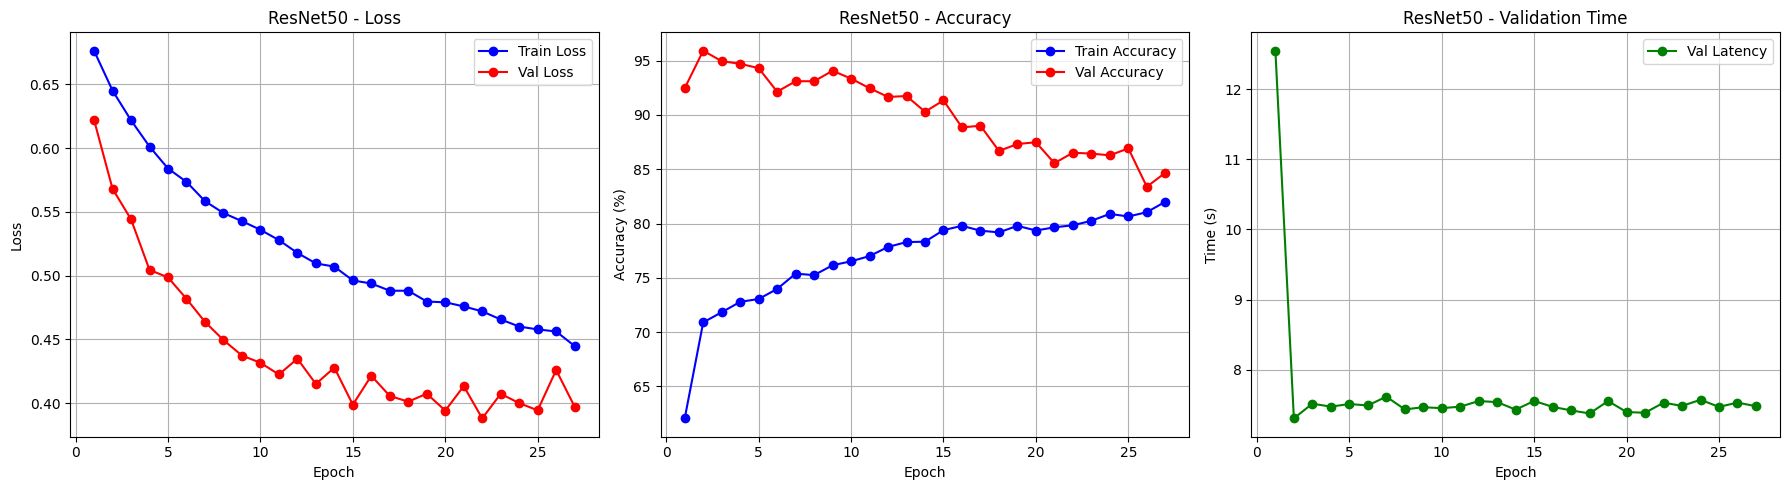

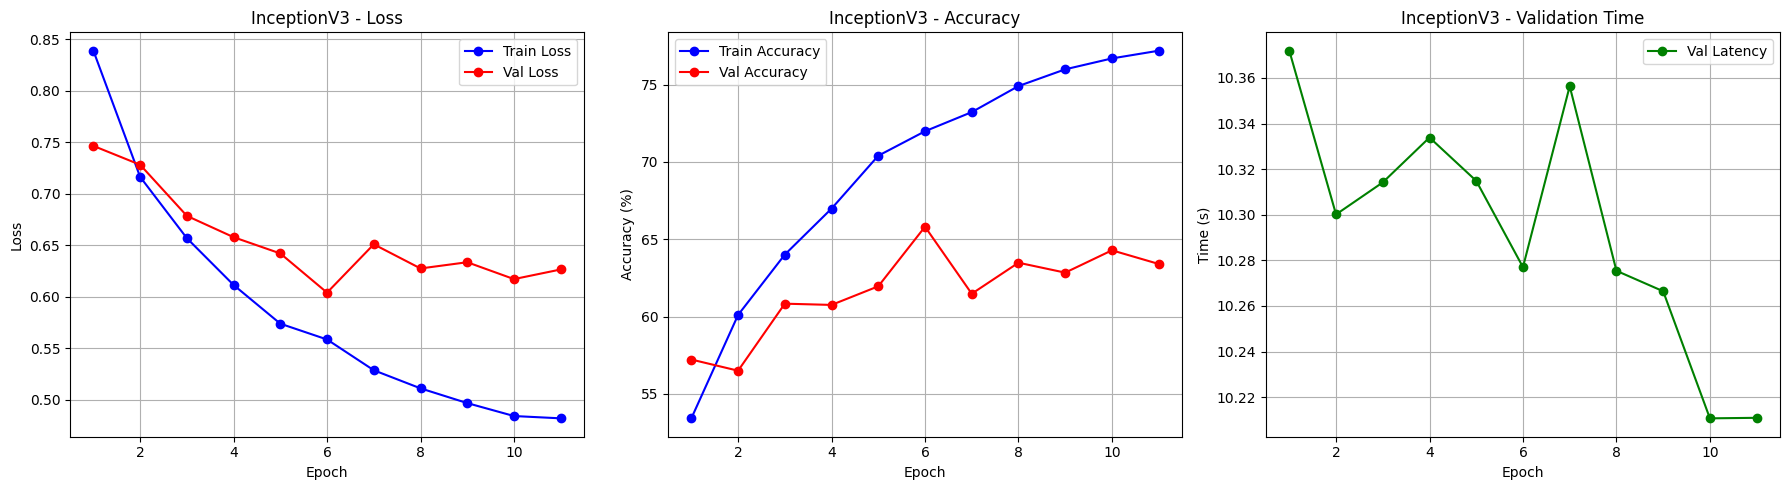

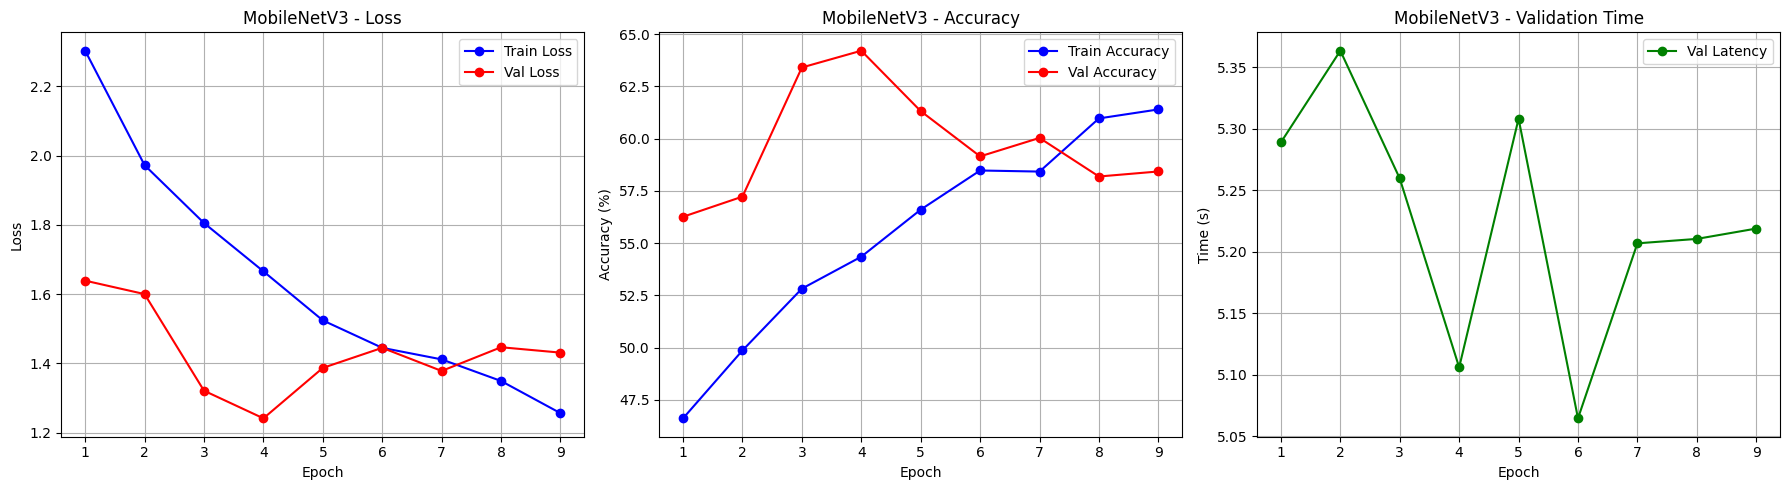


🤖 TRANSFORMER MODELS TRAINING CURVES


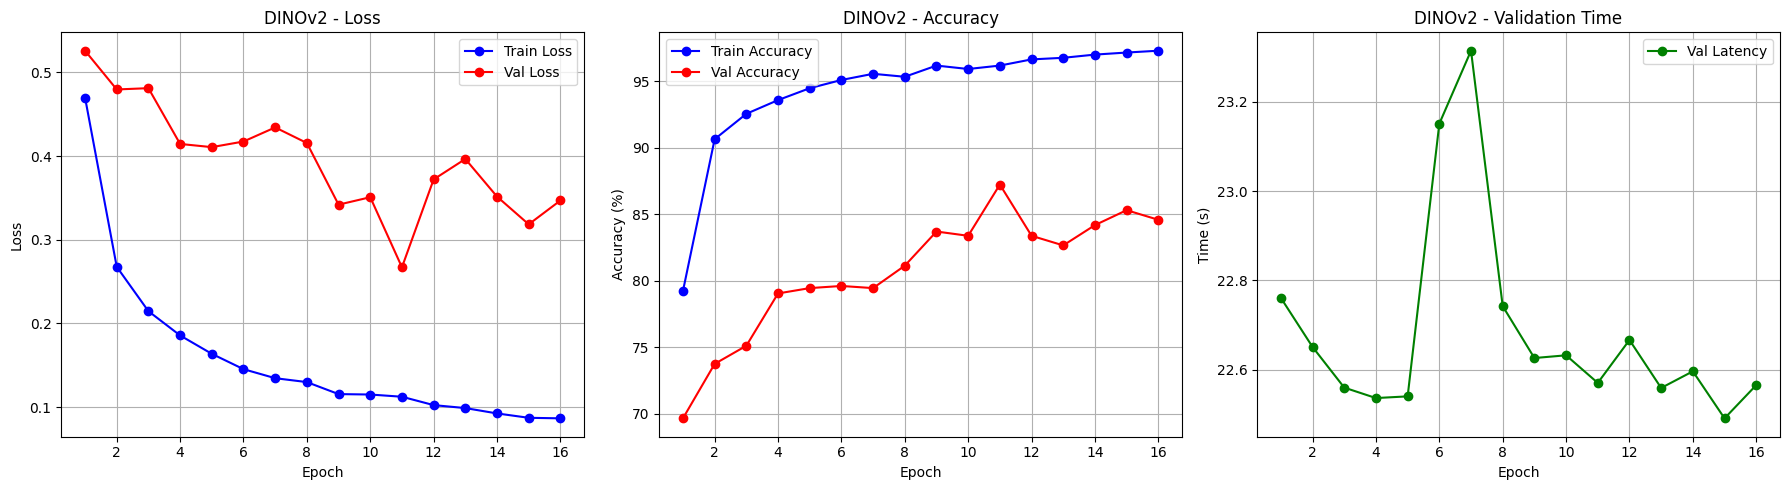

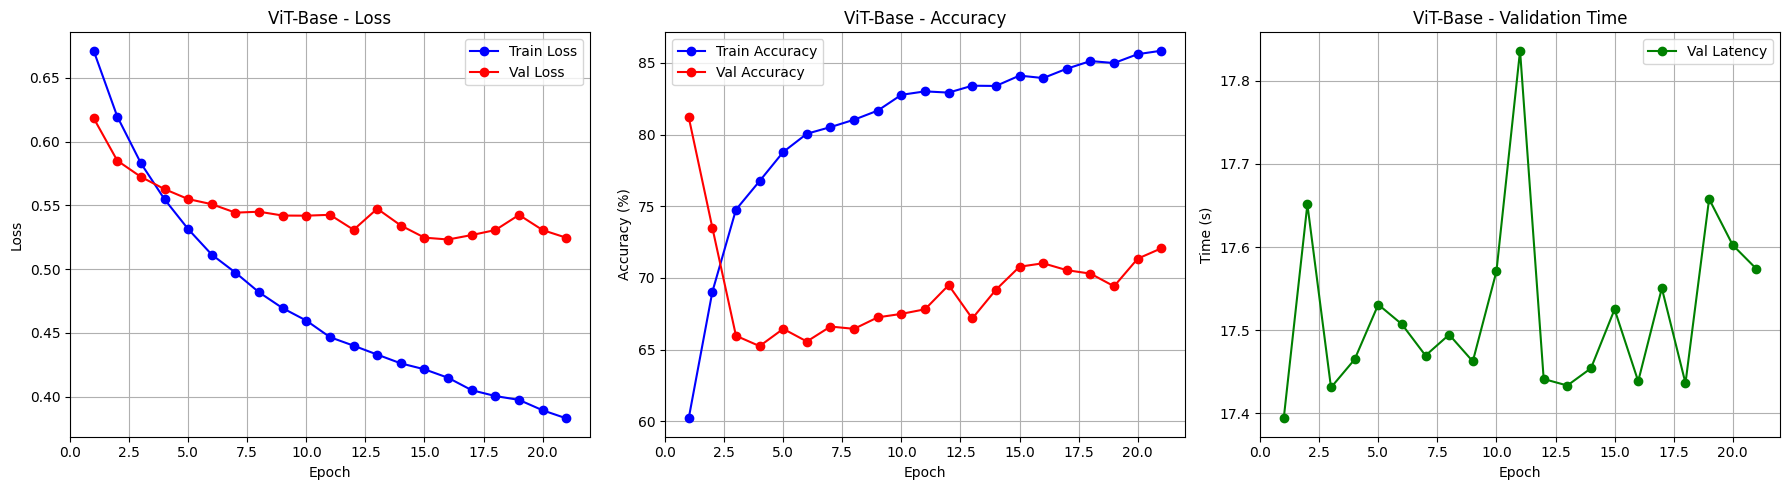

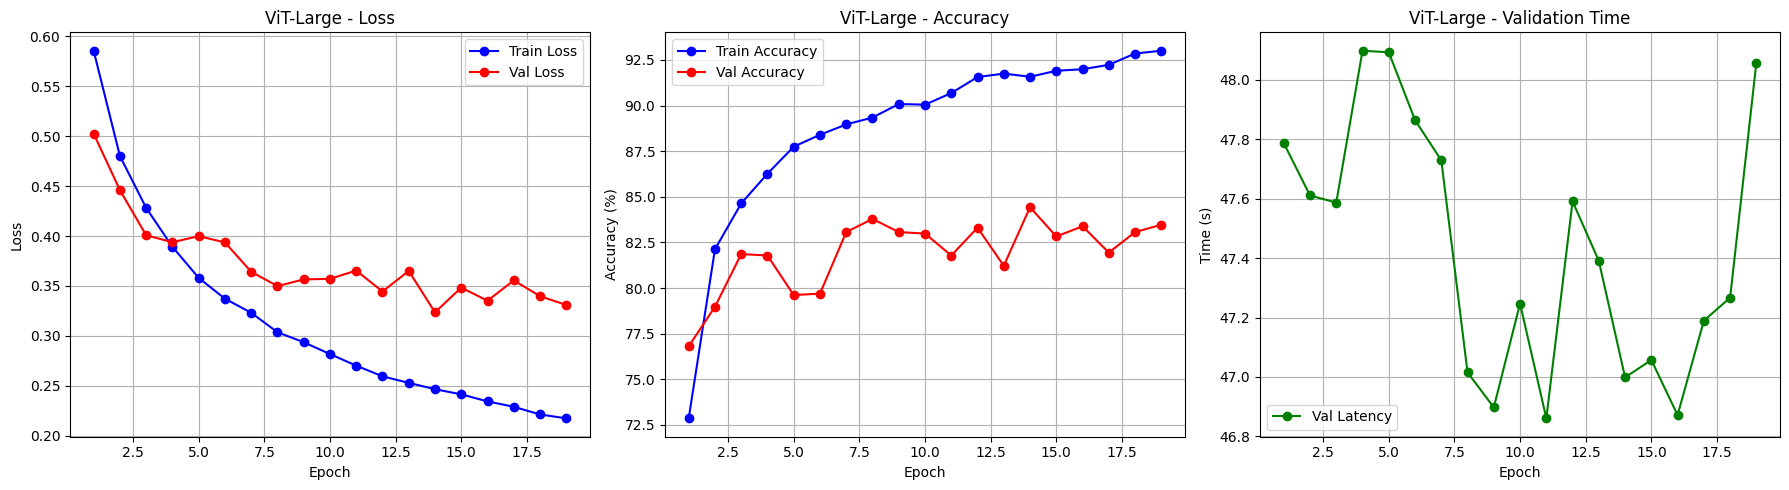

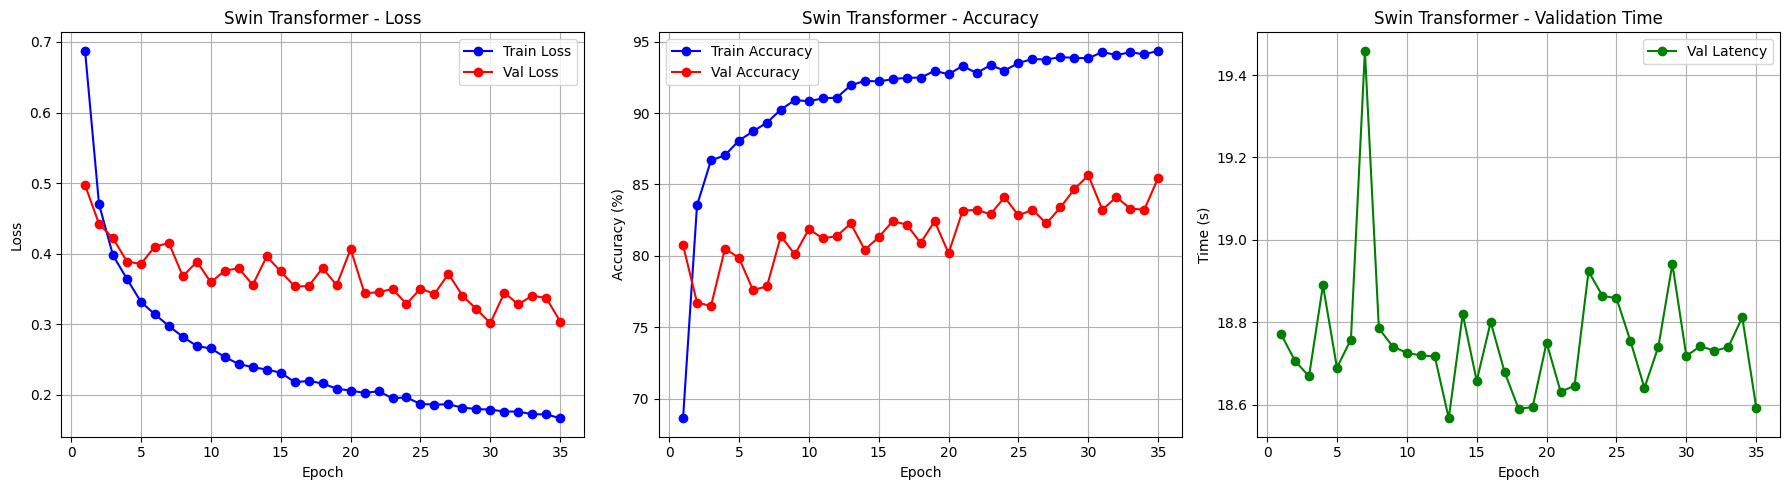

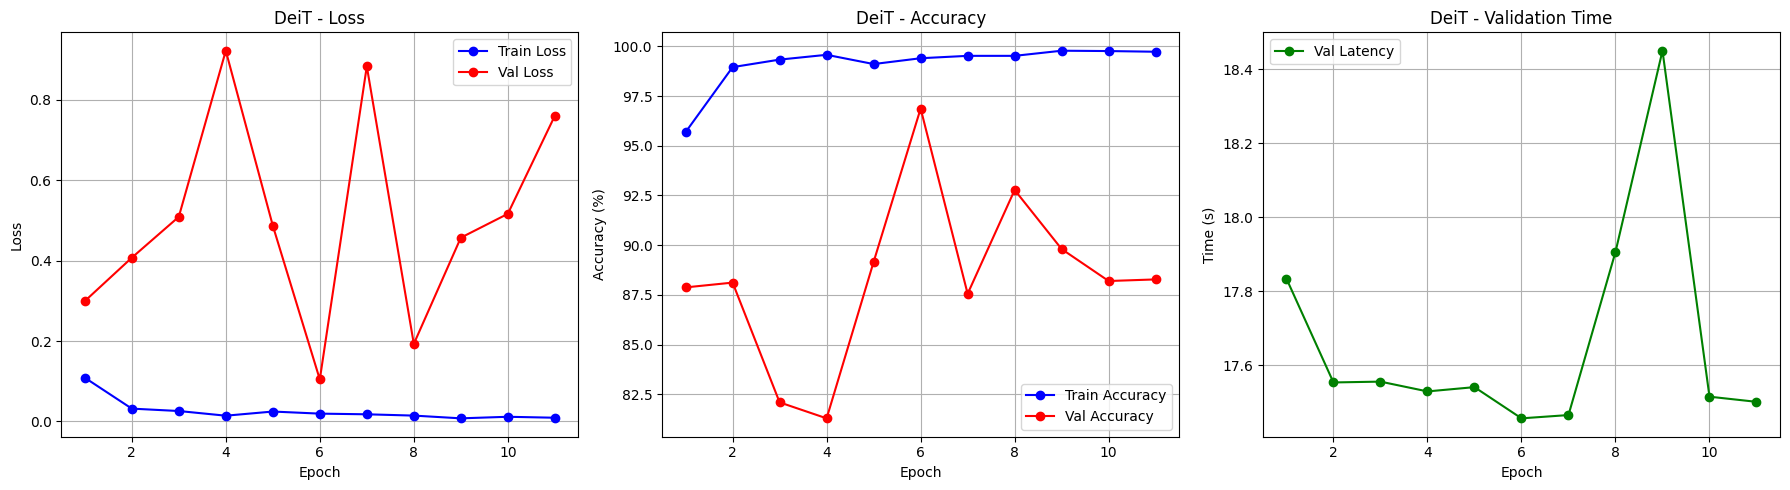

In [33]:
def plot_training_metrics(model_name, train_losses, val_losses, train_accs, val_accs, val_latencies):
    """Plot training and validation metrics."""
    num_epochs_actual = len(train_losses)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss plot
    axes[0].plot(range(1, num_epochs_actual + 1), train_losses, 'o-', label='Train Loss', color='blue')
    axes[0].plot(range(1, num_epochs_actual + 1), val_losses, 'o-', label='Val Loss', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(range(1, num_epochs_actual + 1), train_accs, 'o-', label='Train Accuracy', color='blue')
    axes[1].plot(range(1, num_epochs_actual + 1), val_accs, 'o-', label='Val Accuracy', color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Latency plot
    axes[2].plot(range(1, num_epochs_actual + 1), val_latencies, 'o-', label='Val Latency', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Time (s)')
    axes[2].set_title(f'{model_name} - Validation Time')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot metrics for all models
print("="*70)
print("📊 CNN MODELS TRAINING CURVES")
print("="*70)
plot_training_metrics("ResNet50", resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs, resnet_val_latencies)
plot_training_metrics("InceptionV3", inception_train_losses, inception_val_losses, inception_train_accs, inception_val_accs, inception_val_latencies)
plot_training_metrics("MobileNetV3", mobilenet_train_losses, mobilenet_val_losses, mobilenet_train_accs, mobilenet_val_accs, mobilenet_val_latencies)

print("\n" + "="*70)
print("🤖 TRANSFORMER MODELS TRAINING CURVES")
print("="*70)
plot_training_metrics("DINOv2", dinov2_train_losses, dinov2_val_losses, dinov2_train_accs, dinov2_val_accs, dinov2_val_latencies)
plot_training_metrics("ViT-Base", vit_base_train_losses, vit_base_val_losses, vit_base_train_accs, vit_base_val_accs, vit_base_val_latencies)
plot_training_metrics("ViT-Large", vit_large_train_losses, vit_large_val_losses, vit_large_train_accs, vit_large_val_accs, vit_large_val_latencies)
plot_training_metrics("Swin Transformer", swin_train_losses, swin_val_losses, swin_train_accs, swin_val_accs, swin_val_latencies)
plot_training_metrics("DeiT", deit_train_losses, deit_val_losses, deit_train_accs, deit_val_accs, deit_val_latencies)

## 15. Evaluate All Models on Validation Set

Now we evaluate all 8 trained models on the **validation set** to compare their performance and select the best one.

In [34]:
def evaluate_model(model, dataloader, device, model_name="Model"):
    """
    Evaluate a model on a given dataset (validation or test).
    Returns: accuracy, precision, recall, f1, inference_time
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            # Handle different output formats
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs
            
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    print(f"\n{'='*60}")
    print(f"📊 {model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  Inference Time: {inference_time:.2f}s")
    print(f"{'='*60}\n")
    
    return accuracy, precision, recall, f1, inference_time

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [35]:
# Evaluate all 8 models on validation set
print("\n" + "="*70)
print("🔍 EVALUATING ALL MODELS ON VALIDATION SET")
print("="*70)

# CNN Models
resnet_acc, resnet_prec, resnet_rec, resnet_f1, resnet_inf_time = evaluate_model(
    model_resnet, val_dataloader_224, device, "ResNet50"
)

inception_acc, inception_prec, inception_rec, inception_f1, inception_inf_time = evaluate_model(
    model_inception, val_dataloader_299, device, "InceptionV3"
)

mobilenet_acc, mobilenet_prec, mobilenet_rec, mobilenet_f1, mobilenet_inf_time = evaluate_model(
    model_mobilenet, val_dataloader_224, device, "MobileNetV3"
)

# Transformer Models
dinov2_acc, dinov2_prec, dinov2_rec, dinov2_f1, dinov2_inf_time = evaluate_model(
    model_dinov2, val_dataloader_224, device, "DINOv2"
)

vit_base_acc, vit_base_prec, vit_base_rec, vit_base_f1, vit_base_inf_time = evaluate_model(
    model_vit_base, val_dataloader_224, device, "ViT-Base"
)

vit_large_acc, vit_large_prec, vit_large_rec, vit_large_f1, vit_large_inf_time = evaluate_model(
    model_vit_large, val_dataloader_224, device, "ViT-Large"
)

swin_acc, swin_prec, swin_rec, swin_f1, swin_inf_time = evaluate_model(
    model_swin, val_dataloader_224, device, "Swin Transformer"
)

deit_acc, deit_prec, deit_rec, deit_f1, deit_inf_time = evaluate_model(
    model_deit, val_dataloader_224, device, "DeiT"
)

print("✓ All models evaluated on validation set")


🔍 EVALUATING ALL MODELS ON VALIDATION SET

📊 ResNet50 Evaluation Results
  Accuracy:  0.8467 (84.67%)
  Precision: 0.7776
  Recall:    0.9711
  F1 Score:  0.8637
  Inference Time: 7.57s


📊 InceptionV3 Evaluation Results
  Accuracy:  0.6340 (63.40%)
  Precision: 0.5903
  Recall:    0.8764
  F1 Score:  0.7054
  Inference Time: 10.31s


📊 MobileNetV3 Evaluation Results
  Accuracy:  0.5843 (58.43%)
  Precision: 0.5618
  Recall:    0.7657
  F1 Score:  0.6481
  Inference Time: 5.01s


📊 DINOv2 Evaluation Results
  Accuracy:  0.8459 (84.59%)
  Precision: 0.7718
  Recall:    0.9823
  F1 Score:  0.8644
  Inference Time: 22.98s


📊 ViT-Base Evaluation Results
  Accuracy:  0.7207 (72.07%)
  Precision: 0.6536
  Recall:    0.9390
  F1 Score:  0.7708
  Inference Time: 17.85s


📊 ViT-Large Evaluation Results
  Accuracy:  0.8347 (83.47%)
  Precision: 0.7697
  Recall:    0.9551
  F1 Score:  0.8524
  Inference Time: 46.46s


📊 Swin Transformer Evaluation Results
  Accuracy:  0.8547 (85.47%)
  Precisio

## 16. Model Comparison & Best Model Selection

Compare all 8 models and select the **best model** based on validation performance.

In [36]:
# Create comprehensive comparison table
results_data = {
    'Model': [
        'ResNet50', 'InceptionV3', 'MobileNetV3', 
        'DINOv2', 'ViT-Base', 'ViT-Large', 'Swin Transformer', 'DeiT'
    ],
    'Type': [
        'CNN', 'CNN', 'CNN',
        'Transformer', 'Transformer', 'Transformer', 'Transformer', 'Transformer'
    ],
    'Accuracy': [
        resnet_acc, inception_acc, mobilenet_acc,
        dinov2_acc, vit_base_acc, vit_large_acc, swin_acc, deit_acc
    ],
    'Precision': [
        resnet_prec, inception_prec, mobilenet_prec,
        dinov2_prec, vit_base_prec, vit_large_prec, swin_prec, deit_prec
    ],
    'Recall': [
        resnet_rec, inception_rec, mobilenet_rec,
        dinov2_rec, vit_base_rec, vit_large_rec, swin_rec, deit_rec
    ],
    'F1 Score': [
        resnet_f1, inception_f1, mobilenet_f1,
        dinov2_f1, vit_base_f1, vit_large_f1, swin_f1, deit_f1
    ],
    'Inference Time (s)': [
        resnet_inf_time, inception_inf_time, mobilenet_inf_time,
        dinov2_inf_time, vit_base_inf_time, vit_large_inf_time, swin_inf_time, deit_inf_time
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*100)
print("📋 COMPREHENSIVE MODEL COMPARISON (VALIDATION SET)")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model_acc = results_df.iloc[0]['Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Validation Accuracy: {best_model_acc:.4f} ({best_model_acc*100:.2f}%)")
print(f"   Type: {results_df.iloc[0]['Type']}")
print(f"   F1 Score: {results_df.iloc[0]['F1 Score']:.4f}")
print(f"   Inference Time: {results_df.iloc[0]['Inference Time (s)']:.2f}s")

# Calculate CNN vs Transformer averages
cnn_results = results_df[results_df['Type'] == 'CNN']
transformer_results = results_df[results_df['Type'] == 'Transformer']

print(f"\n" + "="*100)
print("📊 CNN vs TRANSFORMER COMPARISON")
print("="*100)
print(f"\n🔵 CNN Models (Average):")
print(f"   Accuracy:  {cnn_results['Accuracy'].mean():.4f} ({cnn_results['Accuracy'].mean()*100:.2f}%)")
print(f"   Precision: {cnn_results['Precision'].mean():.4f}")
print(f"   Recall:    {cnn_results['Recall'].mean():.4f}")
print(f"   F1 Score:  {cnn_results['F1 Score'].mean():.4f}")
print(f"   Avg Inference Time: {cnn_results['Inference Time (s)'].mean():.2f}s")

print(f"\n🤖 Transformer Models (Average):")
print(f"   Accuracy:  {transformer_results['Accuracy'].mean():.4f} ({transformer_results['Accuracy'].mean()*100:.2f}%)")
print(f"   Precision: {transformer_results['Precision'].mean():.4f}")
print(f"   Recall:    {transformer_results['Recall'].mean():.4f}")
print(f"   F1 Score:  {transformer_results['F1 Score'].mean():.4f}")
print(f"   Avg Inference Time: {transformer_results['Inference Time (s)'].mean():.2f}s")

if cnn_results['Accuracy'].mean() > transformer_results['Accuracy'].mean():
    print(f"\n✓ CNNs perform better on average (+{(cnn_results['Accuracy'].mean() - transformer_results['Accuracy'].mean())*100:.2f}%)")
else:
    print(f"\n✓ Transformers perform better on average (+{(transformer_results['Accuracy'].mean() - cnn_results['Accuracy'].mean())*100:.2f}%)")

print("="*100)


📋 COMPREHENSIVE MODEL COMPARISON (VALIDATION SET)
           Model        Type  Accuracy  Precision   Recall  F1 Score  Inference Time (s)
            DeiT Transformer  0.882825   0.810143 1.000000  0.895115           17.597264
Swin Transformer Transformer  0.854735   0.791557 0.963082  0.868936           18.725990
        ResNet50         CNN  0.846709   0.777635 0.971108  0.863669            7.572459
          DINOv2 Transformer  0.845907   0.771753 0.982343  0.864407           22.976946
       ViT-Large Transformer  0.834671   0.769728 0.955056  0.852436           46.459787
        ViT-Base Transformer  0.720706   0.653631 0.939005  0.770751           17.847245
     InceptionV3         CNN  0.634029   0.590270 0.876404  0.705426           10.313985
     MobileNetV3         CNN  0.584270   0.561837 0.765650  0.648098            5.012693

🏆 BEST MODEL: DeiT
   Validation Accuracy: 0.8828 (88.28%)
   Type: Transformer
   F1 Score: 0.8951
   Inference Time: 17.60s

📊 CNN vs TRANSFORMER

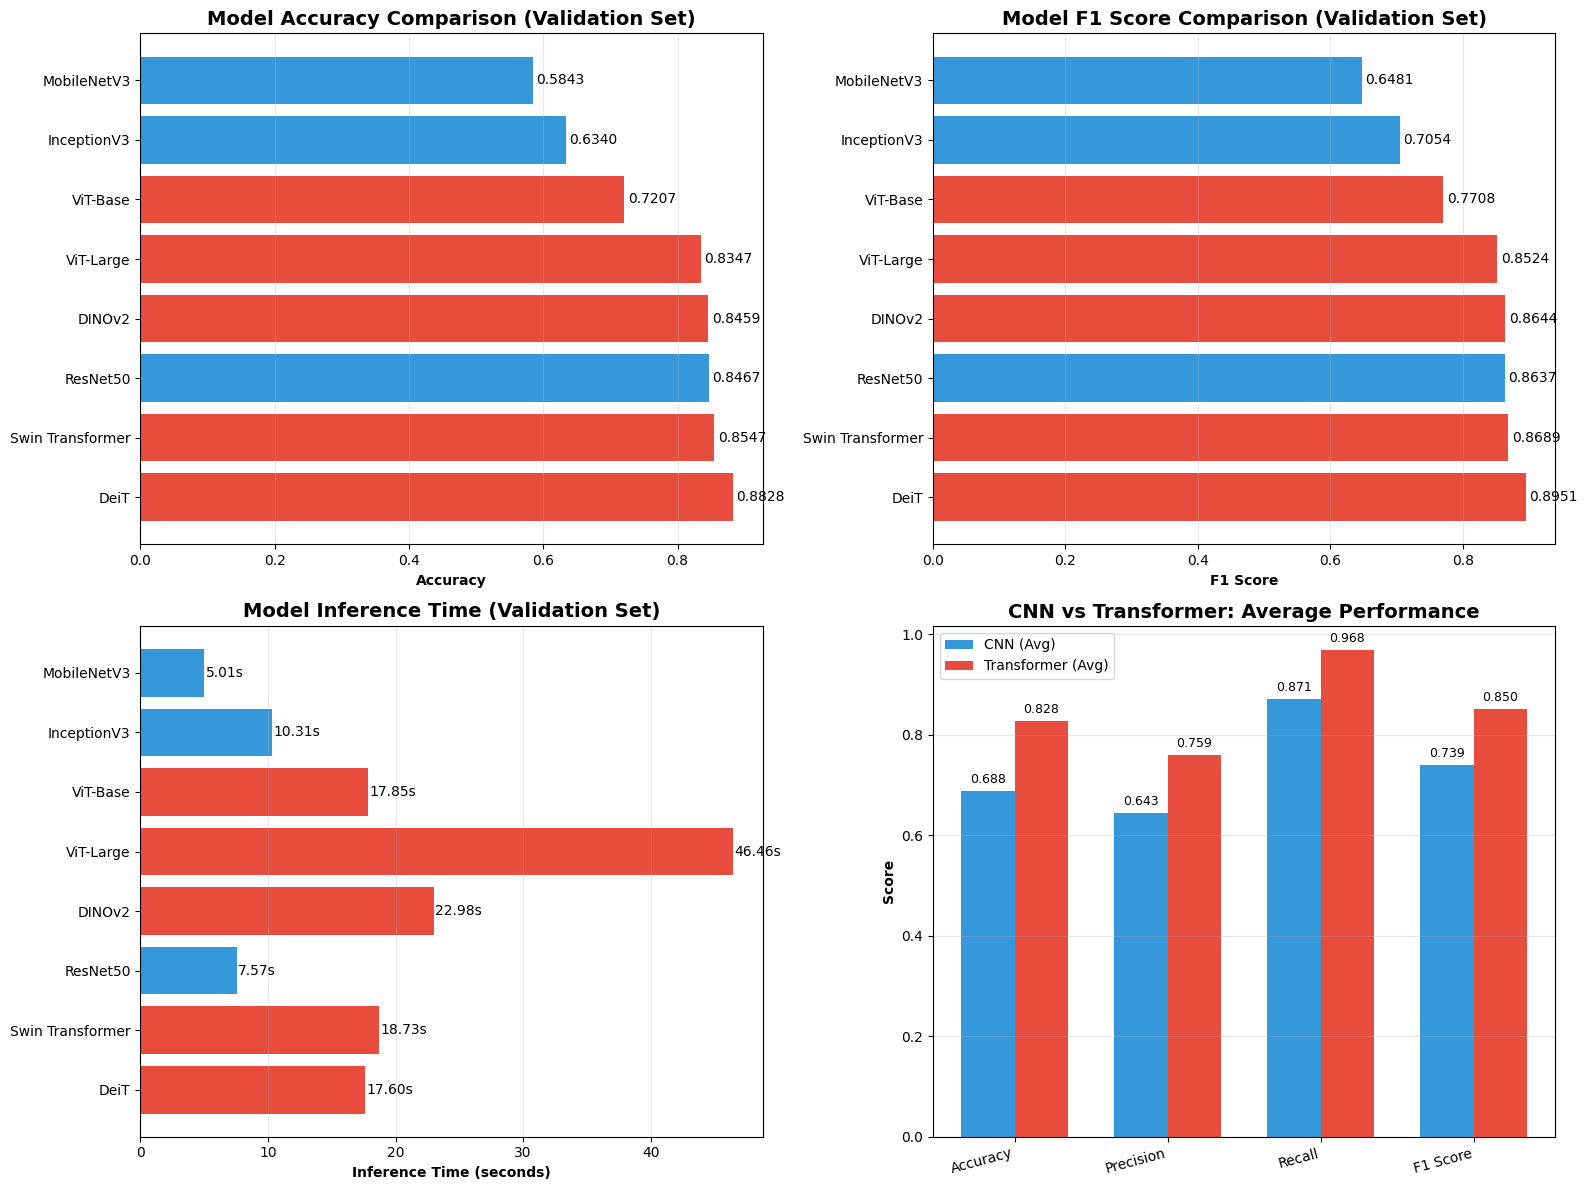

✓ Comparison visualizations generated


In [37]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
colors = ['#3498db' if t == 'CNN' else '#e74c3c' for t in results_df['Type']]
ax1.barh(results_df['Model'], results_df['Accuracy'], color=colors)
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Model Accuracy Comparison (Validation Set)', fontweight='bold', fontsize=14)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Accuracy']):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center')

# 2. F1 Score comparison
ax2 = axes[0, 1]
ax2.barh(results_df['Model'], results_df['F1 Score'], color=colors)
ax2.set_xlabel('F1 Score', fontweight='bold')
ax2.set_title('Model F1 Score Comparison (Validation Set)', fontweight='bold', fontsize=14)
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['F1 Score']):
    ax2.text(v + 0.005, i, f'{v:.4f}', va='center')

# 3. Inference Time comparison
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['Inference Time (s)'], color=colors)
ax3.set_xlabel('Inference Time (seconds)', fontweight='bold')
ax3.set_title('Model Inference Time (Validation Set)', fontweight='bold', fontsize=14)
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Inference Time (s)']):
    ax3.text(v + 0.1, i, f'{v:.2f}s', va='center')

# 4. CNN vs Transformer grouped comparison
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_avg = [cnn_results[m].mean() for m in metrics]
transformer_avg = [transformer_results[m].mean() for m in metrics]

x = np.arange(len(metrics))
width = 0.35
ax4.bar(x - width/2, cnn_avg, width, label='CNN (Avg)', color='#3498db')
ax4.bar(x + width/2, transformer_avg, width, label='Transformer (Avg)', color='#e74c3c')
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('CNN vs Transformer: Average Performance', fontweight='bold', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (c, t) in enumerate(zip(cnn_avg, transformer_avg)):
    ax4.text(i - width/2, c + 0.01, f'{c:.3f}', ha='center', va='bottom', fontsize=9)
    ax4.text(i + width/2, t + 0.01, f'{t:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Comparison visualizations generated")

## 17. Final Test Set Evaluation (Best Model ONLY)

⚠️ **Important:** We evaluate **ONLY the best model** on the test set to get an unbiased final performance estimate.

The test set is used **only once** on the selected best model - never for model selection or tuning.

In [38]:
# Map model names to actual model objects and dataloaders
model_mapping = {
    'ResNet50': (model_resnet, test_dataloader_224),
    'InceptionV3': (model_inception, test_dataloader_299),
    'MobileNetV3': (model_mobilenet, test_dataloader_224),
    'DINOv2': (model_dinov2, test_dataloader_224),
    'ViT-Base': (model_vit_base, test_dataloader_224),
    'ViT-Large': (model_vit_large, test_dataloader_224),
    'Swin Transformer': (model_swin, test_dataloader_224),
    'DeiT': (model_deit, test_dataloader_224)
}

# Get the best model
best_model_obj, best_test_dataloader = model_mapping[best_model_name]

print("\n" + "="*70)
print(f"🏆 FINAL TEST SET EVALUATION - {best_model_name}")
print("="*70)
print(f"This is the ONLY model evaluated on the test set.")
print(f"Selected based on best validation accuracy: {best_model_acc:.4f}")
print("="*70)

# Evaluate on test set
test_acc, test_prec, test_rec, test_f1, test_inf_time = evaluate_model(
    best_model_obj, best_test_dataloader, device, f"{best_model_name} (TEST SET)"
)

print("\n" + "="*70)
print("📊 FINAL RESULTS SUMMARY")
print("="*70)
print(f"Best Model: {best_model_name}")
print(f"\nValidation Performance:")
print(f"  Accuracy:  {best_model_acc:.4f} ({best_model_acc*100:.2f}%)")
print(f"\nTest Performance (Final Unbiased Estimate):")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  Inference Time: {test_inf_time:.2f}s")
print(f"\nGeneralization Gap: {abs(best_model_acc - test_acc)*100:.2f}%")
print("="*70)


🏆 FINAL TEST SET EVALUATION - DeiT
This is the ONLY model evaluated on the test set.
Selected based on best validation accuracy: 0.8828

📊 DeiT (TEST SET) Evaluation Results
  Accuracy:  0.9728 (97.28%)
  Precision: 0.9498
  Recall:    0.9984
  F1 Score:  0.9735
  Inference Time: 24.77s


📊 FINAL RESULTS SUMMARY
Best Model: DeiT

Validation Performance:
  Accuracy:  0.8828 (88.28%)

Test Performance (Final Unbiased Estimate):
  Accuracy:  0.9728 (97.28%)
  Precision: 0.9498
  Recall:    0.9984
  F1 Score:  0.9735
  Inference Time: 24.77s

Generalization Gap: 9.00%


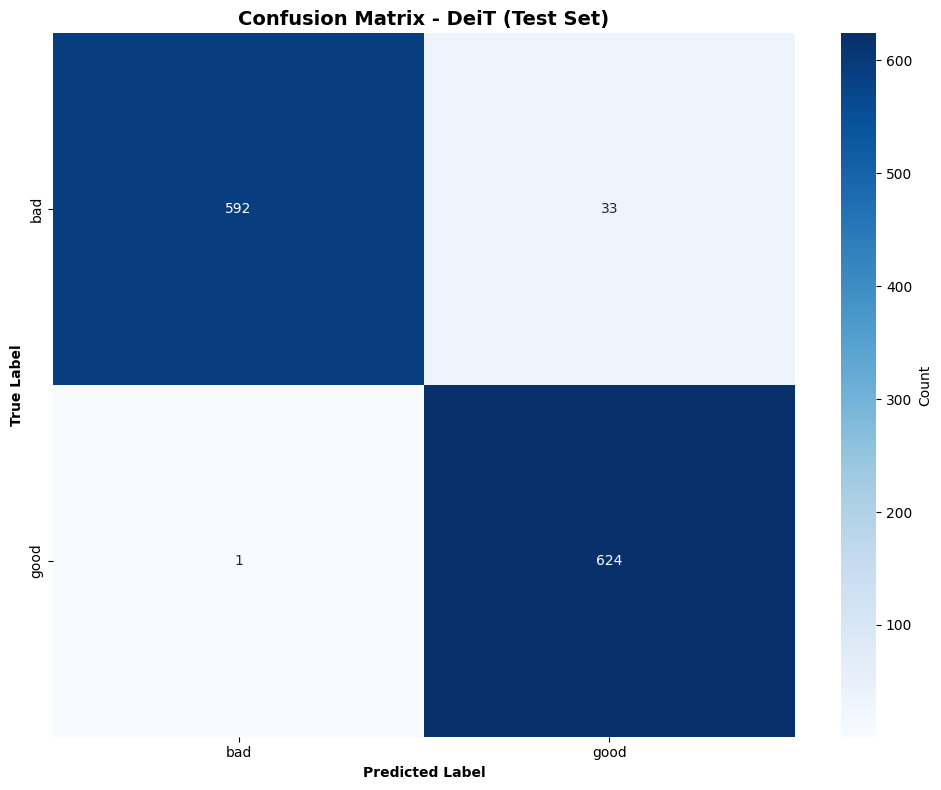


📋 CLASSIFICATION REPORT - DeiT (Test Set)
              precision    recall  f1-score   support

         bad       1.00      0.95      0.97       625
        good       0.95      1.00      0.97       625

    accuracy                           0.97      1250
   macro avg       0.97      0.97      0.97      1250
weighted avg       0.97      0.97      0.97      1250


✓ Final evaluation complete!
✓ Best model (DeiT) has been evaluated on test set
✓ Final test accuracy: 0.9728 (97.28%)


In [39]:
# Generate confusion matrix for best model on test set
best_model_obj.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in best_test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model_obj(inputs)
        
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        elif isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs
        
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*70)
print(f"📋 CLASSIFICATION REPORT - {best_model_name} (Test Set)")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=class_names))
print("="*70)

print("\n✓ Final evaluation complete!")
print(f"✓ Best model ({best_model_name}) has been evaluated on test set")
print(f"✓ Final test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")